<center>
    <h3>
        <a href="https://www.wadhwaniai.org/work/cough-against-covid/">Cough Against COVID-19</a>
    </h3>
    This is a demo notebook to test COVID-19 detector model on a sample cough sound.
</center>

### Instructions for use

1. This notebook tests model on a sample file stored inside `../assets/demo/`
2. In case you want to test it on your own cough sounds, please record a sample on your smartphone and upload `.wav` file to `../assets/demo/` and modify the path to the file.

> **Important Note**: Please understand that these predictions are from a model that has not gone through clinical trials and thus, please treat these predictions only as a demo and consult your medical professionals for clinical advice. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, splitext, exists
from subprocess import call
from IPython.display import Markdown as md
import torch

from cac.config import Config
from cac.utils.logger import set_logger, color
from cac.models import factory as model_factory
from cac.utils.audio import listen_to_audiofile, load_audio
from cac.utils.viz import plot_raw_audio_signal
from utils import _process_raw_audio_file

##### Load trained model

In [27]:
version = "iclrw/cough/v9.7/adamW_1e-4.yml"
config_path = join("experiments", version)

ckpt = 113
ckpt_path = join(splitext(version)[0], f'checkpoints/{ckpt}_ckpt.pth.tar')

# please configure threshold based on model performance on validation set
# for the given model, we observed best threshold to be as follows in order
# to maximize precision at a recall of 90%
threshold = 0.1317

In [28]:
# check if model exists within the repository
assert exists(join("../assets/models", ckpt_path))

In [29]:
# check if config file exists within the repository
assert exists(join('../configs/', config_path))

1. Copy model checkpoint from `assets/models/` to relevant folder

In [30]:
!python ../training/copy_model_ckpts.py -p $ckpt_path

Copying from /workspace/cough-against-covid/assets/models/iclrw/cough/v9.7/adamW_1e-4/checkpoints/113_ckpt.pth.tar to /output//iclrw/cough/v9.7/adamW_1e-4/checkpoints/113_ckpt.pth.tar
sending incremental file list
113_ckpt.pth.tar
    319,202,260 100%    8.80MB/s    0:00:34 (xfr#1, to-chk=0/1)

sent 247,277,308 bytes  received 35 bytes  6,965,558.96 bytes/sec
total size is 319,202,260  speedup is 1.29


2. Load and set config parameters appropriately

In [31]:
config = Config(config_path)

In [32]:
# set logging
set_logger(join(config.log_dir, 'demo_inference.log'))

In [33]:
# add info about the model
config.model['load']['epoch'] = ckpt
config.model['load']['load_best'] = False
config.model['load']['version'] = version.replace(".yml", "")

In [34]:
# set inference directories for logging
dirpaths = ['config_save_path', 'output_dir', 'log_dir', 'checkpoint_dir']
for key in dirpaths:
    train_version = splitext(version)[0]
    infer_version = train_version + "_demo_inference"

    dirpath = getattr(config, key).replace(train_version, infer_version)
    os.makedirs(dirpath, exist_ok=True)
    setattr(config, key + '_demo_inference', dirpath)

In [35]:
model = model_factory.create(config.model['name'], **{'config': config})

Building the network
Removing conv1.weight from state_dict
Removing fc.weight from state_dict
Removing fc.bias from state_dict
Setting up the optimizer ...
=> Loading model weights from /output/iclrw/cough/v9.7/adamW_1e-4/checkpoints/113_ckpt.pth.tar
Freezing specified layers
Using loss functions:
{'train': {'name': 'cross-entropy', 'params': {'reduction': 'none'}}, 'val': {'name': 'cross-entropy', 'params': {'reduction': 'none'}}}


In [36]:
model.network = model.network.eval()

##### Load and process sample audio file

In [37]:
path = '../assets/demo/audios_200_a8fbbdb7.wav'

In [38]:
listen_to_audiofile(path)

In [39]:
signal, rate = load_audio(path)

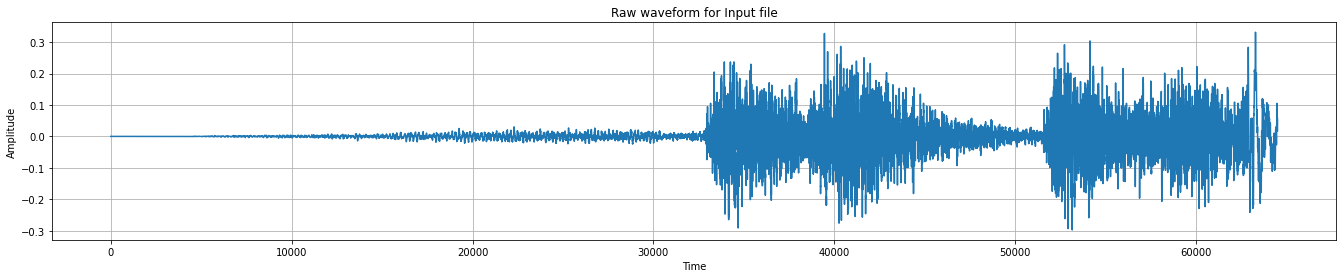

In [40]:
plot_raw_audio_signal(signal, title='Raw waveform for Input file')

In [41]:
signal_transforms = config.data['signal_transform']['val']

In [42]:
batch = _process_raw_audio_file(
    path=path, signal_transforms=signal_transforms, frame_length=500, hop_length=300
)

In [43]:
batch = batch.to(model.device)

In [44]:
batch.shape

torch.Size([4, 1, 64, 201])

##### Forward pass through the model to obtain prediction

In [45]:
# method to aggregate predictions on slided windows
agg_method = config.model['eval']['aggregate']['val']['method']

In [46]:
predictions = model.network(batch)
predicted_proba = torch.nn.functional.softmax(predictions, dim=1)[:, 1]
agg_predicted_proba = getattr(torch, agg_method)(predicted_proba).item()
final_predicted_label = agg_predicted_proba >= threshold

In [47]:
output_string = "<center>Based on the model prediction, <b>COVID-19 is NOT detected in the given audio file</b>. </center>"
if final_predicted_label:
    output_string = "<center>Based on the model prediction, <b>COVID-19 is detected in the given audio file</b>. </center>"

In [48]:
md(output_string)

<center>Based on the model prediction, <b>COVID-19 is detected in the given audio file</b>. </center>

> **Important Note**: Please understand that these predictions are from a model that has not gone through clinical trials and thus, please treat these predictions only as a demo and consult your medical professionals for clinical advice. 